###Load Data

Load Data Section
- Load the preprocessed data
- Check healthy and faulty values
- Check if the data is normalized

In [2]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=False)
%cd /content/drive/My Drive



Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive


In [3]:
import pandas as pd
df_healthy = pd.read_csv('result_healthy_pandas.csv', engine='python', header=None)
df_healthy.head()

,0,1,2,3
0,0,100,0.014603,0.192922
1,1,100,0.054449,0.164364
2,2,100,0.107646,0.090811
3,3,100,0.133722,0.086496
4,4,100,0.112652,0.099235


In [4]:
import numpy
df_faulty = pd.read_csv('result_faulty_pandas.csv', engine='python', header=None)
print(numpy.shape(df_faulty))
df_faulty.head()

(488309, 4)


,0,1,2,3
0,0,107,-0.093238,-0.029175
1,1,107,0.187288,-0.186347
2,2,107,0.217663,-0.341260
3,3,107,0.070172,-0.160871
4,4,107,0.100385,0.179978


Check normalization

In [5]:
import numpy as np
print(np.amax(df_healthy.round(1).loc[:]))
print(np.amin(df_healthy.round(1).loc[:]))

0    1213483.0
1        100.0
2          0.3
3          0.4
dtype: float64
0     0.0
1    97.0
2    -0.3
3    -0.3
dtype: float64


In [6]:
print(np.amax(df_faulty.round(1).loc[:]))
print(np.amin(df_faulty.round(1).loc[:]))

0    488308.0
1       108.0
2         1.7
3         1.0
dtype: float64
0      0.0
1    105.0
2     -1.5
3     -1.2
dtype: float64


### Prepare Sequential

Prepare Sequential Section
- Make the imports
- Write a function to get the signal values for a particular id
- Write a function to get a sequence length and reshape the data to a sequence. As an example, if our data shape is (1000,2) , meaning we have two types of sensors and 1000 recordings, and if we have sequence length 10 (which will be used in LSTM), we reshape our data to (100,10,2)
- Also, before reshaping, trim the data so the length of all data can be divided to sequence length. 
- Note that we could also make our data a sequence, with repetition of data points. We will talk about this in Oil Prices example.

In [24]:
import numpy as np
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat


In [8]:
def get_recording(df,file_id):
    return np.array(df.sort_values(by=0, ascending=True).loc[df[1] == file_id].drop(columns = [0,1]))

def create_trimmed_recording(df,file_id,timesteps,dim):
    recording = get_recording(df,file_id) 
    samples = len(recording)
    trim = samples % 100
    trimmed = samples-trim
    recording_trimmed = recording[:trimmed]
    recording_trimmed.shape = (int((trimmed)/timesteps),timesteps,dim)
    return recording_trimmed


In [9]:
#pd.unique()
#df_healthy.drop(0,1).drop(2,1).drop(3,1)
pd.unique(df_healthy.iloc[:,1])

array([100,  98,  97])

### Model

Prepare Sequential Section
- Make the imports
- Write a class to log the loss values. We will plot the losses to see the anomaly.
- Write an LSTM autoencoder which has one hidden layer.
- Write functions to perform fit and get predictions
- Write a training loop to train on healthy samples. Note that we fit to each id seperately.
- Plot the losses of healthy samples reconstructed.
- Write a training loop to train on faulty samples. Note that we fit to each id seperately.
- Plot the losses of healthy samples reconstructed and faulty samples reconstructed together. We should see that faulty samples are reconstructed with a higher loss, making us able to realize that there is an anomaly, just by looking to the reconstruction loss. This is an unsupervised learning example.

In [10]:
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import LSTM, Dense, Activation
from keras.callbacks import Callback


import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import time

%matplotlib inline

Using TensorFlow backend.


In [11]:
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

In [18]:
timesteps = 100
dim = 2
lossHistory = LossHistory()
# design network

model = Sequential()
model.add(LSTM(50,input_shape=(timesteps,dim),return_sequences=True))
model.add(Dense(2))
model.compile(loss='mae', optimizer='adam')

def train(data):
    model.fit(data, data, epochs=5, batch_size=72, validation_data=(data, data), verbose=1, shuffle=False,callbacks=[lossHistory])

def score(data):
    yhat =  model.predict(data)
    return yhat

In [19]:
file_ids = pd.unique(df_healthy.iloc[:,1])
start = time.time()
for file_id in file_ids:
    recording_trimmed = create_trimmed_recording(df_healthy,file_id,timesteps,dim)
    print("Staring training on %s" % (file_id))
    #train(recording_trimmed)
    model.fit(recording_trimmed, recording_trimmed, epochs=5, batch_size=72, validation_data=(recording_trimmed, recording_trimmed), verbose=1, shuffle=False,callbacks=[lossHistory])
    print("Finished training on %s after %s seconds" % (file_id,time.time()-start))

print("Finished job on after %s seconds" % (time.time()-start))
healthy_losses = lossHistory.losses


Staring training on 100
Train on 4856 samples, validate on 4856 samples
Epoch 1/5
4856/4856 [==============================] - 11s 2ms/step - loss: 0.0433 - val_loss: 0.0338
Epoch 2/5
4856/4856 [==============================] - 11s 2ms/step - loss: 0.0235 - val_loss: 0.0122
Epoch 3/5
4856/4856 [==============================] - 11s 2ms/step - loss: 0.0095 - val_loss: 0.0074
Epoch 4/5
4856/4856 [==============================] - 11s 2ms/step - loss: 0.0054 - val_loss: 0.0046
Epoch 5/5
4856/4856 [==============================] - 11s 2ms/step - loss: 0.0042 - val_loss: 0.0038
Finished training on 100 after 55.45870351791382 seconds
Staring training on 98
Train on 4839 samples, validate on 4839 samples
Epoch 1/5
4839/4839 [==============================] - 11s 2ms/step - loss: 0.0034 - val_loss: 0.0029
Epoch 2/5
4839/4839 [==============================] - 11s 2ms/step - loss: 0.0068 - val_loss: 0.0103
Epoch 3/5
4839/4839 [==============================] - 11s 2ms/step - loss: 0.0061 - v

In [20]:
healthy_losses = lossHistory.losses

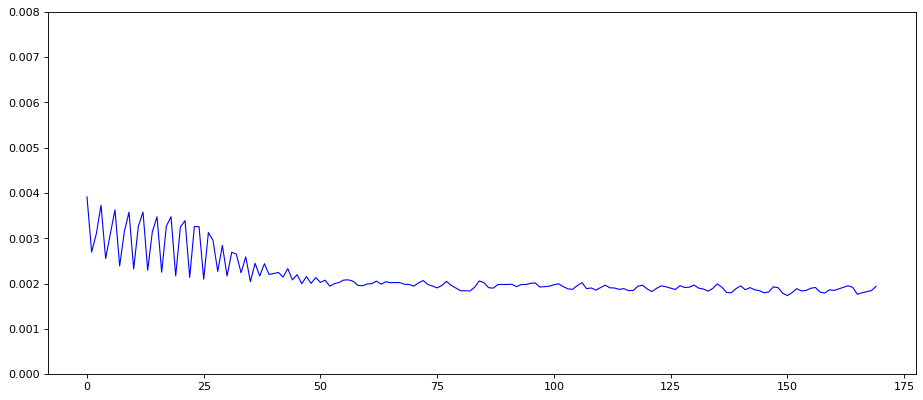

In [21]:
fig, ax = plt.subplots(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
size = len(healthy_losses)
plt.ylim(0,0.008)
ax.plot(range(0,size), healthy_losses, '-', color='blue', animated = True, linewidth=1)

In [22]:
file_ids = pd.unique(df_faulty.iloc[:,1])
start = time.time()
for file_id in file_ids:
    recording_trimmed = create_trimmed_recording(df_faulty,file_id,timesteps,dim)
    print("Staring training on %s" % (file_id))
    model.fit(recording_trimmed, recording_trimmed, epochs=1, batch_size=72, validation_data=(recording_trimmed, recording_trimmed), verbose=1, shuffle=False,callbacks=[lossHistory])
    print("Finished training on %s after %s seconds" % (file_id,time.time()-start))

print("Finished job on after %s seconds" % (time.time()-start))
faulty_losses = lossHistory.losses


Staring training on 107
Train on 1221 samples, validate on 1221 samples
Epoch 1/1
1221/1221 [==============================] - 3s 2ms/step - loss: 0.0229 - val_loss: 0.0159
Finished training on 107 after 3.045583486557007 seconds
Staring training on 105
Train on 1212 samples, validate on 1212 samples
Epoch 1/1
1212/1212 [==============================] - 3s 2ms/step - loss: 0.0131 - val_loss: 0.0107
Finished training on 105 after 5.888619422912598 seconds
Staring training on 108
Train on 1229 samples, validate on 1229 samples
Epoch 1/1
1229/1229 [==============================] - 3s 3ms/step - loss: 0.0097 - val_loss: 0.0085
Finished training on 108 after 9.087488174438477 seconds
Staring training on 106
Train on 1219 samples, validate on 1219 samples
Epoch 1/1
1219/1219 [==============================] - 3s 2ms/step - loss: 0.0078 - val_loss: 0.0072
Finished training on 106 after 12.08701205253601 seconds
Finished job on after 12.087242603302002 seconds


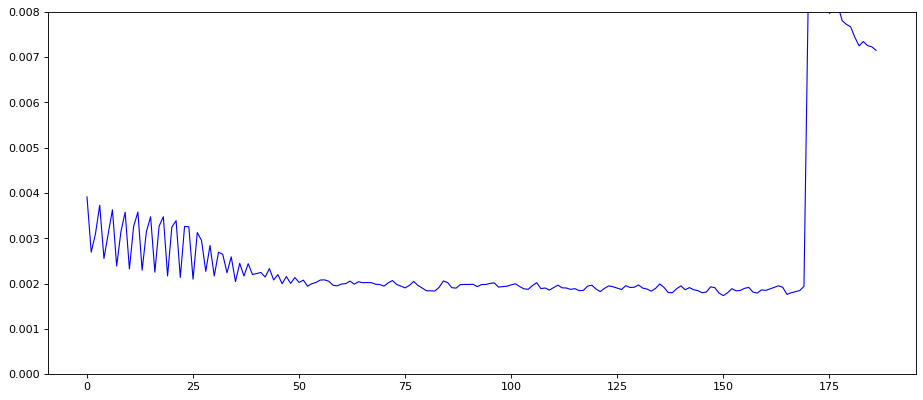

In [23]:
fig, ax = plt.subplots(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
size = len(healthy_losses+faulty_losses)
plt.ylim(0,0.008)
ax.plot(range(0,size), healthy_losses+faulty_losses, '-', color='blue', animated = True, linewidth=1)